# Kyoto Protocol, world performance analysis

## Library

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import gmaps

# pip install plotly==4.7.0

# 1. Data wrangling
### 1st Dataset - (1)mean exposure levels to PM2.5 by country and (2)percentage of people exposed to different air pollution levels by country

In [2]:
#Read 1st dataframe containing the air pollution levels per country
air_pollution_raw = pd.read_csv("PM2_5_pollution_exposure.csv")
air_pollution_raw.head(3)

Country Macroregion Microregion                           Variable  Year  \
0  Australia     -Total-     -Total-  Mean population exposure to PM2.5  1990   
1  Australia     -Total-     -Total-  Mean population exposure to PM2.5  2010   
2  Australia     -Total-     -Total-  Mean population exposure to PM2.5  2011   

                         Unit PowerCode  Reference Period     Value  Flags  
0  Micrograms per cubic metre     Units               NaN  10.36402    NaN  
1  Micrograms per cubic metre     Units               NaN  10.53559    NaN  
2  Micrograms per cubic metre     Units               NaN  10.88267    NaN

In [3]:
#Remove useless columns
clean_air_pollution = air_pollution_raw.drop(["Macroregion", "Microregion", "PowerCode",
                                                 "Reference Period", "Flags"], axis = 1)
print(len(clean_air_pollution))
clean_air_pollution.head(10)

7352


Country                                           Variable  Year  \
0  Australia                  Mean population exposure to PM2.5  1990   
1  Australia                  Mean population exposure to PM2.5  2010   
2  Australia                  Mean population exposure to PM2.5  2011   
3  Australia                  Mean population exposure to PM2.5  2012   
4  Australia                  Mean population exposure to PM2.5  2013   
5  Australia                  Mean population exposure to PM2.5  2014   
6  Australia                  Mean population exposure to PM2.5  2015   
7  Australia                  Mean population exposure to PM2.5  2016   
8  Australia  Percentage of population exposed to more than ...  1990   
9  Australia  Percentage of population exposed to more than ...  2010   

                         Unit     Value  
0  Micrograms per cubic metre  10.36402  
1  Micrograms per cubic metre  10.53559  
2  Micrograms per cubic metre  10.88267  
3  Micrograms per cubic metre  10.40148  
4  Micrograms per cubic metre   9.84329  
5  Micrograms per cubic metre   9.36117  
6  Micrograms per cubic metre   9.20277  
7  Micrograms per cubic metre   8.53581  
8                  Percentage  32.18407  
9                  Percentage  34.08280

In [4]:
#Check how many variable names are contained in "Variable" column
clean_air_pollution["Variable"].value_counts()

Percentage of population exposed to more than 10 micrograms/m3    1472
Percentage of population exposed to more than 25 micrograms/m3    1472
Percentage of population exposed to more than 35 micrograms/m3    1472
Percentage of population exposed to more than 15 micrograms/m3    1472
Mean population exposure to PM2.5                                 1464
Name: Variable, dtype: int64

In [5]:
clean_air_pollution["Country"].value_counts()

Barbados          40
Cabo Verde        40
Paraguay          40
Hungary           40
Comoros           40
                  ..
Fiji              40
Suriname          40
Poland            40
Moldova           40
Cayman Islands    32
Name: Country, Length: 184, dtype: int64

There are 8 missing values from the __"Mean population exposure to PM2.5"__ variable, all of them coming from __"Cayman Islands"__. Due to its low potential significance in its contribution to the world air pollution, we decided to get rid of the entire record for this country. 

In [6]:
#Remove Cayman Islands from dataframe
cayman = clean_air_pollution.loc[clean_air_pollution["Country"] == "Cayman Islands"].index
cleaner_air_pollution = clean_air_pollution.drop(cayman, axis = 0)

In [7]:
#Raname variable and unit names to make it easier to read
cleaner_air_pollution = cleaner_air_pollution.replace({"Variable" :
                                                 {"Mean population exposure to PM2.5": "Mean exposure level to PM2.5",
                                                 "Percentage of population exposed to more than 10 micrograms/m3" : "Pop exposed > 10µg/m3",
                                                 "Percentage of population exposed to more than 15 micrograms/m3" : "Pop exposed > 15µg/m3",
                                                 "Percentage of population exposed to more than 25 micrograms/m3" : "Pop exposed > 25µg/m3",
                                                 "Percentage of population exposed to more than 35 micrograms/m3" : "Pop exposed > 35µg/m3"}})

cleaner_air_pollution = cleaner_air_pollution.replace({"Unit" : {"Micrograms per cubic metre" : "µg/m3"}})
cleaner_air_pollution

Country                      Variable  Year   Unit     Value
0     Australia  Mean exposure level to PM2.5  1990  µg/m3  10.36402
1     Australia  Mean exposure level to PM2.5  2010  µg/m3  10.53559
2     Australia  Mean exposure level to PM2.5  2011  µg/m3  10.88267
3     Australia  Mean exposure level to PM2.5  2012  µg/m3  10.40148
4     Australia  Mean exposure level to PM2.5  2013  µg/m3   9.84329
...         ...                           ...   ...    ...       ...
7331       Iran  Mean exposure level to PM2.5  2012  µg/m3  38.80363
7332       Iran  Mean exposure level to PM2.5  2013  µg/m3  38.42392
7333       Iran  Mean exposure level to PM2.5  2014  µg/m3  38.27532
7334       Iran  Mean exposure level to PM2.5  2015  µg/m3  39.97714
7335       Iran  Mean exposure level to PM2.5  2016  µg/m3  39.19964

[7320 rows x 5 columns]

In [8]:
#Create an independent dataframe containing only the mean exposure level per country
mean_air_pollution = cleaner_air_pollution.copy()
index_mean = mean_air_pollution.loc[cleaner_air_pollution["Variable"] != "Mean exposure level to PM2.5"].index
mean_air_pollution = mean_air_pollution.drop(index_mean, axis = 0)
print(len(mean_air_pollution))
mean_air_pollution.head()

1464


Country                      Variable  Year   Unit     Value
0  Australia  Mean exposure level to PM2.5  1990  µg/m3  10.36402
1  Australia  Mean exposure level to PM2.5  2010  µg/m3  10.53559
2  Australia  Mean exposure level to PM2.5  2011  µg/m3  10.88267
3  Australia  Mean exposure level to PM2.5  2012  µg/m3  10.40148
4  Australia  Mean exposure level to PM2.5  2013  µg/m3   9.84329

### 2nd Dataset - Deaths due to air pollution diseases by country

In [9]:
#Read 2nd dataframe containing the deaths due to air pollution diseases
deaths_raw = pd.read_csv("death_rates_air_pollution.csv")
print(len(deaths_raw))
deaths_raw

6468


Entity Code  Year  \
0     Afghanistan  AFG  1990   
1     Afghanistan  AFG  1991   
2     Afghanistan  AFG  1992   
3     Afghanistan  AFG  1993   
4     Afghanistan  AFG  1994   
...           ...  ...   ...   
6463     Zimbabwe  ZWE  2013   
6464     Zimbabwe  ZWE  2014   
6465     Zimbabwe  ZWE  2015   
6466     Zimbabwe  ZWE  2016   
6467     Zimbabwe  ZWE  2017   

      Deaths - Air pollution - Sex: Both - Age: Age-standardized (Rate) (deaths per 100,000)  
0                                            299.477309                                       
1                                            291.277967                                       
2                                            278.963056                                       
3                                            278.790815                                       
4                                            287.162923                                       
...                                                 ...                                       
6463                                         143.850145                                       
6464                                         138.200536                                       
6465                                         132.752553                                       
6466                                         128.692138                                       
6467                                         125.028843                                       

[6468 rows x 4 columns]

In [10]:
#Rename column name for convenience
deaths_raw.rename(columns = {"Deaths - Air pollution - Sex: Both - Age: Age-standardized (Rate) (deaths per 100,000)" :
                             "Deaths per 100,000"}, inplace = True)
deaths_raw

Entity Code  Year  Deaths per 100,000
0     Afghanistan  AFG  1990          299.477309
1     Afghanistan  AFG  1991          291.277967
2     Afghanistan  AFG  1992          278.963056
3     Afghanistan  AFG  1993          278.790815
4     Afghanistan  AFG  1994          287.162923
...           ...  ...   ...                 ...
6463     Zimbabwe  ZWE  2013          143.850145
6464     Zimbabwe  ZWE  2014          138.200536
6465     Zimbabwe  ZWE  2015          132.752553
6466     Zimbabwe  ZWE  2016          128.692138
6467     Zimbabwe  ZWE  2017          125.028843

[6468 rows x 4 columns]

In [11]:
#Merge mean_air_pollution and deaths_raw dataframes
levels_deaths_df = mean_air_pollution.merge(deaths_raw, left_on = ["Country", "Year"], right_on = ["Entity", "Year"])
levels_deaths_df

Country                      Variable  Year   Unit     Value  \
0     Australia  Mean exposure level to PM2.5  1990  µg/m3  10.36402   
1     Australia  Mean exposure level to PM2.5  2010  µg/m3  10.53559   
2     Australia  Mean exposure level to PM2.5  2011  µg/m3  10.88267   
3     Australia  Mean exposure level to PM2.5  2012  µg/m3  10.40148   
4     Australia  Mean exposure level to PM2.5  2013  µg/m3   9.84329   
...         ...                           ...   ...    ...       ...   
1315       Iran  Mean exposure level to PM2.5  2012  µg/m3  38.80363   
1316       Iran  Mean exposure level to PM2.5  2013  µg/m3  38.42392   
1317       Iran  Mean exposure level to PM2.5  2014  µg/m3  38.27532   
1318       Iran  Mean exposure level to PM2.5  2015  µg/m3  39.97714   
1319       Iran  Mean exposure level to PM2.5  2016  µg/m3  39.19964   

         Entity Code  Deaths per 100,000  
0     Australia  AUS           26.705027  
1     Australia  AUS           13.571713  
2     Australia  AUS           13.727626  
3     Australia  AUS           12.659725  
4     Australia  AUS           11.874490  
...         ...  ...                 ...  
1315       Iran  IRN           46.800381  
1316       Iran  IRN           46.328081  
1317       Iran  IRN           46.446436  
1318       Iran  IRN           47.209842  
1319       Iran  IRN           46.640540  

[1320 rows x 8 columns]

In [12]:
#Rename "Value" column to be able to remove non-esencial columns
levels_deaths_df.rename(columns = {"Value" :
                             "Mean exposure to PM2.5 (µg/m3)"}, inplace = True)

air_poll = levels_deaths_df.drop(["Variable", "Unit", "Entity","Code"], axis = 1)
air_poll.head()

Country  Year  Mean exposure to PM2.5 (µg/m3)  Deaths per 100,000
0  Australia  1990                        10.36402           26.705027
1  Australia  2010                        10.53559           13.571713
2  Australia  2011                        10.88267           13.727626
3  Australia  2012                        10.40148           12.659725
4  Australia  2013                         9.84329           11.874490

### New column - Status of ratification

In [13]:
ratified_countries = ["Albania", "Algeria", "Angola", "Antigua and Barbuda", "Argentina",
                     "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas",
                     "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
                     "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina",
                     "Botswana", "Brazil", "Bulgaria", "Burkina Faso", "Burundi",
                     "Cambodia", "Cameroon", "Canada", "Cape Verde", "Central African Republic",
                     "Chile", "China", "Colombia", "Comoros", "Congo",
                     "Cook Islands", "Costa Rica", "Cote D\'Ivoire", "Croatia", "Cuba",
                     "Cyprus", "Czech Republic", "Democratic Peoples Republic of Korea", "Denmark", "Djibouti",
                     "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador",
                     "Equatorial Guinea", "Eritrea", "Estonia", "Ethiopia", "Fiji",
                     "Finland", "France", "Gabon", "Gambia", "Georgia",
                     "Germany", "Ghana", "Greece", "Grenada", "Guatemala",
                     "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras",
                     "Hungary", "Iceland", "India", "Indonesia", "Iran",
                     "Ireland", "Israel", "Italy", "Jamaica", "Japan",
                     "Jordan", "Kenya", "Kiribati", "Kuwait",
                     "Kyrgyzstan", "Lao Democratic Republic", "Latvia", "Lebanon", "Lesotho",
                     "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg",
                     "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
                     "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico",
                     "Micronesia", "Monaco", "Mongolia", "Montenegro", "Morocco",
                     "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal",
                     "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria",
                     "Niue", "Norway", "Oman", "Pakistan", "Palau", "Panama",
                     "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland",
                     "Portugal", "Qatar", "Republic of Korea", "Republic of Moldova", "Romania",
                     "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
                     "Samoa", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Serbia",
                     "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia",
                     "Solomon Islands", "South Africa", "Spain", "Sri Lanka", "Sudan",
                     "Suriname", "Swaziland", "Sweden", "Switzerland", "Syrian Arab Republic",
                     "Tajikistan", "Thailand", "Macedonia", "Timor-Leste", "Togo",
                     "Tonga", "Trinidad and Tobago", "Tunisia", "Turkmenistan", "Tuvalu",
                     "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "Tanzania",
                     "Uruguay", "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam",
                     "Yemen", "Zambia"]

In [14]:
#Add a column "Ratified" with the status of ratification of the Kyoto Protocol for each country 
#air_poll["Ratified Kyoto P."] = ""

for index, row in air_poll.iterrows():
    if row["Country"] in ratified_countries:
        air_poll.loc[index, 'Ratified Kyoto P.'] = True
        
    else:
        air_poll.loc[index, 'Ratified Kyoto P.'] = False
        
air_poll.head()

Country  Year  Mean exposure to PM2.5 (µg/m3)  Deaths per 100,000  \
0  Australia  1990                        10.36402           26.705027   
1  Australia  2010                        10.53559           13.571713   
2  Australia  2011                        10.88267           13.727626   
3  Australia  2012                        10.40148           12.659725   
4  Australia  2013                         9.84329           11.874490   

  Ratified Kyoto P.  
0              True  
1              True  
2              True  
3              True  
4              True

### 3rd Dataset - Coordinates for each country

In [15]:
coords_raw = pd.read_csv("coords_country.csv")
coords_raw.head()

country   latitude  longitude                  name
0      AD  42.546245   1.601554               Andorra
1      AE  23.424076  53.847818  United Arab Emirates
2      AF  33.939110  67.709953           Afghanistan
3      AG  17.060816 -61.796428   Antigua and Barbuda
4      AI  18.220554 -63.068615              Anguilla

In [16]:
#To cut longitude and latitude to 3 decimals
coords_raw["longitude"] = ["{:.3f}".format(lng) for lng in coords_raw["longitude"]]
coords_raw["latitude"] = ["{:.3f}".format(lat) for lat in coords_raw["latitude"]]

In [17]:
#Remove "country" column
coords_raw = coords_raw.drop(["country"], axis = 1)

In [18]:
#Change columns names
coords_raw.rename(columns = {"latitude" : "Latitude", "longitude" : "Longitude"}, inplace = True)

In [19]:
#2nd merge: air_poll and coords_raw
complete_air_poll = air_poll.merge(coords_raw, left_on = ["Country"], right_on = ["name"])
#Remove "name column"
complete_air_poll = complete_air_poll.drop(["name"], axis = 1)

### Final dataframe

In [20]:
complete_air_poll

Country  Year  Mean exposure to PM2.5 (µg/m3)  Deaths per 100,000  \
0     Australia  1990                        10.36402           26.705027   
1     Australia  2010                        10.53559           13.571713   
2     Australia  2011                        10.88267           13.727626   
3     Australia  2012                        10.40148           12.659725   
4     Australia  2013                         9.84329           11.874490   
...         ...   ...                             ...                 ...   
1291       Iran  2012                        38.80363           46.800381   
1292       Iran  2013                        38.42392           46.328081   
1293       Iran  2014                        38.27532           46.446436   
1294       Iran  2015                        39.97714           47.209842   
1295       Iran  2016                        39.19964           46.640540   

     Ratified Kyoto P. Latitude Longitude  
0                 True  -25.274   133.775  
1                 True  -25.274   133.775  
2                 True  -25.274   133.775  
3                 True  -25.274   133.775  
4                 True  -25.274   133.775  
...                ...      ...       ...  
1291              True   32.428    53.688  
1292              True   32.428    53.688  
1293              True   32.428    53.688  
1294              True   32.428    53.688  
1295              True   32.428    53.688  

[1296 rows x 7 columns]

In [21]:
#Create lists for the country members of G7 and G20
g7 = ["Canada", "France", "Germany", "Italy", "Japan", "United Kingdom", "United States"]

g20 = ["Argentina", "Australia", "Brazil", "Canada", "China", "France", "Germany", "India", "Indonesia", "Italy", "Japan",
      "Mexico", "Russia", "Saudi Arabia", "South Africa", "South Korea", "Turkey", "United Kingdom", "United States"]

# 2. Analysis
### Part 1 - World performance maps

In [22]:
#Calculate the mean for both variables per country
complete_air_poll_stat = complete_air_poll.groupby("Country").agg({"Deaths per 100,000":"mean",
                                                                "Mean exposure to PM2.5 (µg/m3)":"mean"})

In [23]:
complete_air_poll_stat = complete_air_poll_stat.reset_index()
complete_air_poll_stat["Deaths per 100,000"] = complete_air_poll_stat["Deaths per 100,000"].map("{:.2f}".format)
complete_air_poll_stat["Mean exposure to PM2.5 (µg/m3)"] = complete_air_poll_stat["Mean exposure to PM2.5 (µg/m3)"].map("{:.2f}".format)
complete_air_poll_stat.head()

Country Deaths per 100,000 Mean exposure to PM2.5 (µg/m3)
0  Afghanistan             214.69                          63.23
1      Albania              48.33                          20.77
2      Algeria              47.94                          36.06
3      Andorra              18.64                          14.78
4       Angola             123.77                          33.64

### World performance map 1: Mean exposure to PM2.5

In [24]:
complete_air_poll_stat['text1'] = 'micrograms/m3'


fig_4 = go.Figure(data=go.Choropleth(
    locations=complete_air_poll_stat['Country'], 
    z = complete_air_poll_stat['Mean exposure to PM2.5 (µg/m3)'], 
    locationmode = 'country names', 
    colorscale = [[0, 'rgb(7, 64, 80)'], [1,'rgb(169, 220, 103)']],
    zmin = 5,
    zmax = 92,
    autocolorscale=False,
    reversescale=True,
    text=complete_air_poll_stat['text1'],
    marker_line_color='rgb(46, 46, 46)',
    colorbar_ticksuffix = ' µg/m3',
    colorbar_title="Air pollution concentration"
))

fig_4.update_layout(
    title_text= "Mean Exposure to Particulate Matter 2.5<br>(2010-2016)",
    geo=dict(
        showframe=True,
        showcoastlines=True,
        projection_type="natural earth",
        showocean = True,
        oceancolor = "rgb(169, 234, 245)"
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source:OECD',
        showarrow = False,
    )]
)

fig_4.show()

The earlier map shows the average exposure to particulate matter 2.5 from 2010-2016. The map indicates that the countries that are the most exposed to this particle are India (South Asia), Saudi Arabia (Western Asia), and some African nations like Niger, Egypt, and Chad. Latin American, Caribean and South American countries are exposed significantly to PM2.5, however, it can be said that their numbers are presumably lower compared to the aforementioned nations.

### World performance map 2: Deaths per 100,000 population due to air pollution

In [25]:
#complete_air_poll_stat['text'] = 'deaths per 100,000' 
    

fig_1 = go.Figure(data=go.Choropleth(
    locations=complete_air_poll_stat['Country'], 
    z = complete_air_poll_stat['Deaths per 100,000'],
    locationmode = "country names",
    hovertext = 'deaths per 100,000 p.',
    colorscale = [[0, 'rgb(240, 183, 41)'], [1,'rgb(110, 0, 84)']],
    zmin = 10,
    zmax = 210,
    reversescale=False,
    #text=complete_air_poll_stat['text'],
    autocolorscale=False,
    marker_line_color='rgb(191, 96, 8)',
    colorbar_title="Deaths per 100k pop."
))

fig_1.update_layout(
    title_text= "Average Death Rate per 100,000 population<br>(2010-2016)",
        geo=dict(
        showframe=True,
        showcoastlines=True,
        projection_type="natural earth",
        showocean = True,
        oceancolor = "rgb(169, 234, 245)"
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: Our World in Data',
        showarrow = False,
    )]
)

fig_1.show()

The previous world map shows an overview of the average number of deaths per 100,000 population per country from 2010-2016 due to air pollution. As can be noted, the countries that have the highest number of deaths attributed to air pollution are found in Middle and eastern Africa, and southern Asia. Countries like Papua New Guinea, situated in the southwestern pacific ocean, Afghanistan, Central Africa, and Somalia stand out on the map. In the case of America, the central and south regions have the countries with a higher number of deaths, being these Guatemala and Bolivia. Finally, as can be seen, within Europe, the western region concentrates the countries with the highest number of deaths, being Serbia and Ukraine the ones that stand out.

### Part 2 - Evolution over the years

### Evolution over the years 1: Mean Exposure to PM2.5

In [26]:
table_exposure = complete_air_poll.pivot_table(index="Country", 
                                         columns="Year",
                                         values="Mean exposure to PM2.5 (µg/m3)")

In [27]:
mean_exposure = pd.DataFrame(table_exposure.mean(axis=0))
mean_exposure.index = map(int, mean_exposure.index)
mean_exposure.reset_index(inplace = True)
mean_exposure.columns = ["year", "total"]
mean_exposure

year      total
0  1990  29.941792
1  2010  29.274662
2  2011  29.521107
3  2012  28.944567
4  2013  28.204453
5  2014  27.158964
6  2015  29.141692
7  2016  27.845614

Do you want to save the Figure (yes/no): no


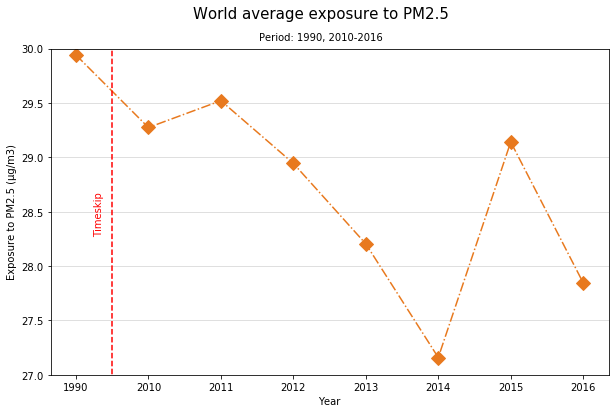

In [28]:
x_axis = np.arange(1,9,1)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, mean_exposure["total"],
        color = "#e8791e",
        marker = "D",
        markersize = 10,
        linestyle = "dashdot",
        linewidth = 1.5)


plt.xticks(x_axis, ["1990","2010","2011","2012","2013", "2014", "2015", "2016"])
plt.figtext(.5,.95,"World average exposure to PM2.5", fontsize = 15, ha="center")
plt.figtext(.5,.9, "Period: 1990, 2010-2016", ha = "center")
plt.xlabel('Year')
plt.ylabel('Exposure to PM2.5 (µg/m3)')

plt.axvline(x=1.5, ymin=-15, ymax=35, color="r", linestyle = "--")
plt.figtext(.185,.45, "Timeskip", color = "r", rotation = 90)
plt.grid(axis = "y", alpha = .5)
plt.ylim(27,30)

answer_2 = input("Do you want to save the Figure (yes/no): ")
if answer_2 == "yes":
    namefile_2 = input("Provide the name of the file: ")
    plt.savefig(f"{namefile_2}_scatter.png")
    
plt.show()

The previous graph illustrates the change of the mean exposure to PM2.5 of 1990, and from the 2010-2016 period. It can be said that exposure decreased from 1990 to 2016. However, something that worth mentioning is the rebound from 2014 to 2015 and again a decrease in 2016. An explanation of the situation that occurred in 2015 is going to be discussed later in the writing.

### Evolution over the years 2: Death rates per 100k population

In [29]:
table_deaths = complete_air_poll.pivot_table(index="Country", 
                                         columns="Year",
                                         values="Deaths per 100,000")

In [30]:
table_deaths.head()

Year               1990        2010        2011        2012        2013  \
Country                                                                   
Afghanistan  299.477309  221.525572  214.332694  207.388702  200.905640   
Albania       82.828947   45.393400   45.473407   43.891073   43.241173   
Algeria       66.759231   46.567033   46.220693   45.259175   45.001784   
Andorra       29.023881   18.281500   18.384001   17.675487   17.189342   
Angola       224.508667  123.461373  117.943545  113.698391  109.869922   

Year               2014        2015        2016  
Country                                          
Afghanistan  195.436958  191.801119  186.668949  
Albania       42.522622   42.299773   41.018788  
Algeria       44.781956   44.362524   44.539094  
Andorra       16.315473   16.652146   15.606827  
Angola       103.291785  100.239480   97.124529

In [31]:
mean_deaths = pd.DataFrame(table_deaths.mean(axis=0))
mean_deaths.index = map(int, mean_deaths.index)
mean_deaths.reset_index(inplace = True)
mean_deaths.columns = ["year", "total"]
mean_deaths

year       total
0  1990  106.570807
1  2010   77.075610
2  2011   75.610647
3  2012   73.571625
4  2013   71.885989
5  2014   70.135722
6  2015   69.508829
7  2016   67.639062

Do you want to save the Figure (yes/no): no


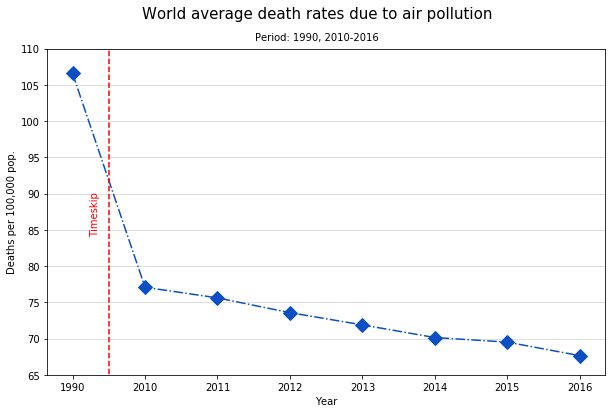

In [32]:
x_axis = np.arange(1,9,1)
plt.figure(figsize=(10, 6))
plt.plot(x_axis, mean_deaths["total"],
        color = "#0c4fc4",
        marker = "D",
        markersize = 10,
        linestyle = "dashdot",
        linewidth = 1.5)


plt.xticks(x_axis, ["1990","2010","2011","2012","2013", "2014", "2015", "2016"])
plt.figtext(.5,.95,"World average death rates due to air pollution", fontsize = 15, ha="center")
plt.figtext(.5,.9, "Period: 1990, 2010-2016", ha = "center")
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000 pop.')

plt.axvline(x=1.5, ymin=-15, ymax=35, color="r", linestyle = "--")
plt.figtext(.185,.45, "Timeskip", color = "r", rotation = 90)
plt.grid(axis = "y", alpha = .5)
plt.ylim(65,110)

answer_2 = input("Do you want to save the Figure (yes/no): ")
if answer_2 == "yes":
    namefile_2 = input("Provide the name of the file: ")
    plt.savefig(f"{namefile_2}_scatter.png")
    
plt.show()

The last graph shows the change in deaths per 100,000 population of 1990, and from 2010-2016. This one certainly indicates a decrease in deaths due to air pollution in the aforementioned year and period.

### Part 3 - Variable correlation: Exposure to PM2.5 vs. Death rates

In [33]:
#function definition
def linearreg(x_val, y_val,df, prefix_title):
    slope, intercept, r_value, p_value, std_err = sts.linregress(x_val,y_val)
    plt.figure(figsize=(10, 6))
    sns.regplot(x = x_val, y = y_val,
                line_kws = {'label': "y= {0:.1f}x + {1:.1f}".format(slope,intercept)},
                data = df,
               scatter_kws = {"s": x_val, "marker" : "o", "color" : "#17a803", "alpha" : 0.75, "edgecolors" : "#005912"})
    
    plt.xlim(0, max(x_val)+3)
    plt.grid(axis = "y", alpha = .5)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    plt.axvline(x=12, color = "#e39400", label = "moderate")
    plt.axvline(x=35, color = "#e36200", label = "sensitive groups")
    plt.axvline(x=55, color = "#e30000", label = "unhealthy")
    plt.legend()
    plt.title(f"{prefix_title} - Exposure to PM2.5 vs. Deaths rates", fontsize = 15)
    
    
    answer = input("Do you want to save the Figure (yes/no): ")
    if answer == "yes":
        namefile = input("Provide the name of the file: ")
        plt.savefig(f"{namefile}_scatter.png")
        
    print("------------------------------------------------")
    print(f"The correlation coefficient is {round(sts.pearsonr(x_val,y_val)[0],2)}")
    print(f"the r-squared is: {round(r_value**2,2)}")
    print(f"The mean exposure to PM2.5 is {round(x_val.mean(),2)}")
    print(f"The mean of deaths per 100,000 population is {round(y_val.mean(),2)}")
    
    plt.show()

### World average

Do you want to save the Figure (yes/no): no
------------------------------------------------
The correlation coefficient is 0.45
the r-squared is: 0.2
The mean exposure to PM2.5 is 28.75
The mean of deaths per 100,000 population is 76.5


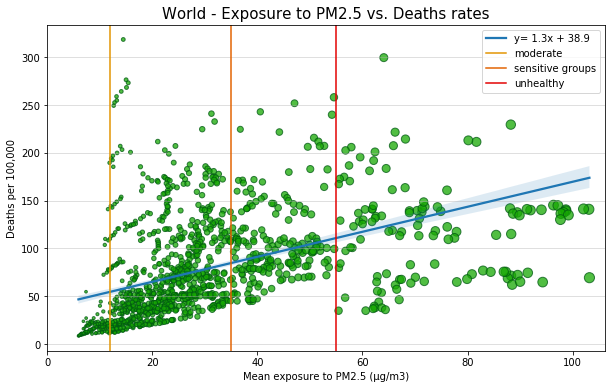

In [34]:
Fig1 = linearreg(complete_air_poll ["Mean exposure to PM2.5 (µg/m3)"],
        complete_air_poll ["Deaths per 100,000"], complete_air_poll, "World")

The graph shows the relationship between Mean exposure to PM2.5 and deaths per 100,000 population due to air pollution. The results indicate a weak positive correlation between both factors. Also, the r-squared value suggests that the linear regression model may not accurately predict the number of deaths with different exposure levels.

### Countries that signed and ratified Kyoto Protocol

Do you want to save the Figure (yes/no): no
------------------------------------------------
The correlation coefficient is 0.43
the r-squared is: 0.18
The mean exposure to PM2.5 is 28.49
The mean of deaths per 100,000 population is 74.85


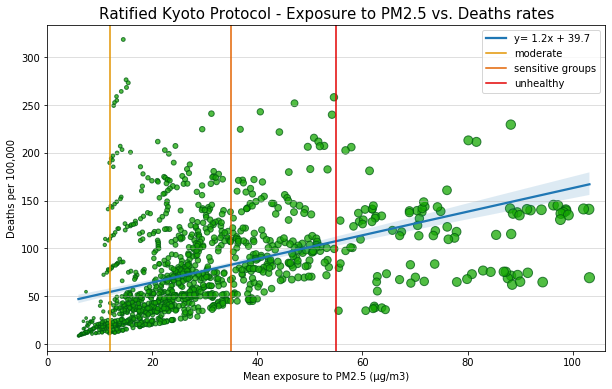

In [35]:
ratified_df = complete_air_poll.loc[complete_air_poll["Ratified Kyoto P."]==True]
linearreg(ratified_df["Mean exposure to PM2.5 (µg/m3)"],
         ratified_df["Deaths per 100,000"],
         ratified_df, "Ratified Kyoto Protocol")

### Countries outside Kyoto Protocol

Do you want to save the Figure (yes/no): no
------------------------------------------------
The correlation coefficient is 0.59
the r-squared is: 0.34
The mean exposure to PM2.5 is 33.2
The mean of deaths per 100,000 population is 104.51


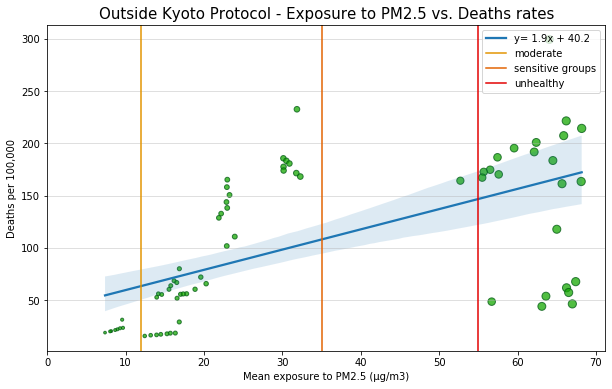

In [36]:
no_ratified = complete_air_poll.loc[complete_air_poll["Ratified Kyoto P."]==False]
linearreg(no_ratified["Mean exposure to PM2.5 (µg/m3)"],
       no_ratified["Deaths per 100,000"], no_ratified, "Outside Kyoto Protocol")

Next, two scatter plots of the same factors were made. The first one considered only the countries that signed and ratified the Kyoto agreement, and the second one was made with countries that did not ratify it. If both are compared, it can be seen that the correlation between exposure to PM2.5 and deaths due to air pollution is higher in countries that did not ratify the agreement (moderate positive correlation) than the ones who did it. Also, the linear model appears to fit better in the second group. Finally, something that should be noted is the difference between the means of both groups, being the values of the countries that signed and ratified the agreement lower than the ones who did not continue with the protocol.

### G7 Countries

Do you want to save the Figure (yes/no): no
------------------------------------------------
The correlation coefficient is 0.29
the r-squared is: 0.09
The mean exposure to PM2.5 is 12.58
The mean of deaths per 100,000 population is 19.1


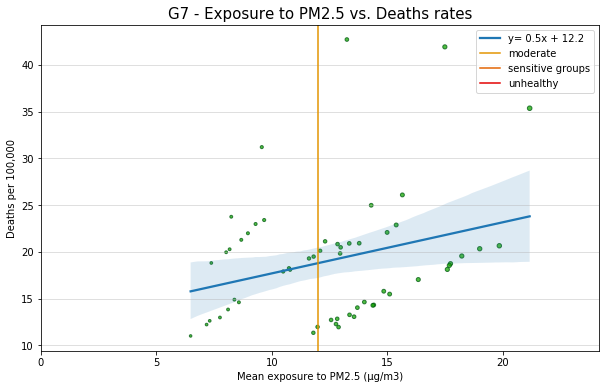

In [37]:
g7_countries_df = complete_air_poll.loc[complete_air_poll["Country"].isin(g7)]
linearreg(g7_countries_df["Mean exposure to PM2.5 (µg/m3)"],
        g7_countries_df["Deaths per 100,000"],g7_countries_df, "G7")

### G20 Countries

Do you want to save the Figure (yes/no): no
------------------------------------------------
The correlation coefficient is 0.77
the r-squared is: 0.6
The mean exposure to PM2.5 is 24.71
The mean of deaths per 100,000 population is 43.3


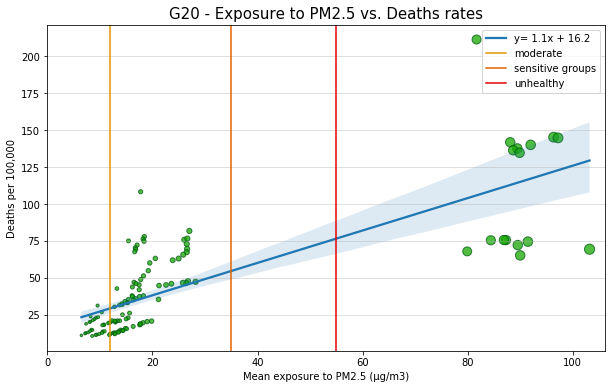

In [38]:
g20_countries_df = complete_air_poll.loc[complete_air_poll["Country"].isin(g20)]
linearreg(g20_countries_df["Mean exposure to PM2.5 (µg/m3)"],
        g20_countries_df["Deaths per 100,000"],g20_countries_df, "G20")

The next comparison was made between the countries that belong to the G7 group and the ones that are members of the G20 group. At first, it can be seen that the correlation between both factors is much higher in the G20 group, being this a strong positive correlation. Also, the r-squared value indicates that the regression equation of this group model the data much better than in the G7 countries. That is, the number of deaths might be predicted more accurately with different exposure to PM2.5. In addition, the mean values of both factors are clearly lower in the G7 group than in the G20 group. The latter is also seen on the scale of both groups. In the case of the first group, there may be other factors that influence death due to pollution. 

### Rest of  the countries

In [39]:
rest_countries = []
unique_countries =[]
for index, row in complete_air_poll.iterrows():
    if (row["Country"] not in g7) & (row["Country"] not in g20):
        rest_countries.append(row["Country"])
        for country in rest_countries:
            if country not in unique_countries:
                unique_countries.append(country)
                
rest_countries_df = complete_air_poll.loc[complete_air_poll["Country"].isin(unique_countries)]

In [40]:
mean_rest_countries = rest_countries_df.groupby("Year")["Mean exposure to PM2.5 (µg/m3)"].mean()
mean_g7_countries_df = g7_countries_df.groupby("Year")["Mean exposure to PM2.5 (µg/m3)"].mean()
mean_g20_countries_df = g20_countries_df.groupby("Year")["Mean exposure to PM2.5 (µg/m3)"].mean()
groups_exposure_df = pd.DataFrame({"Rest of countries": mean_rest_countries,
                          "G7 Countries": mean_g7_countries_df,
                          "G20 Countries":mean_g20_countries_df})
groups_exposure_df

Rest of countries  G7 Countries  G20 Countries
Year                                                
1990          30.502072     14.234494      24.829234
2010          29.652675     13.371824      25.825299
2011          29.899260     13.625393      26.070469
2012          29.376855     12.604597      24.999933
2013          28.581978     12.338409      24.759532
2014          27.575448     11.735420      23.358542
2015          29.634342     11.756987      24.646268
2016          28.355557     10.934203      23.192387

Do you want to save the Figure (yes/no): no


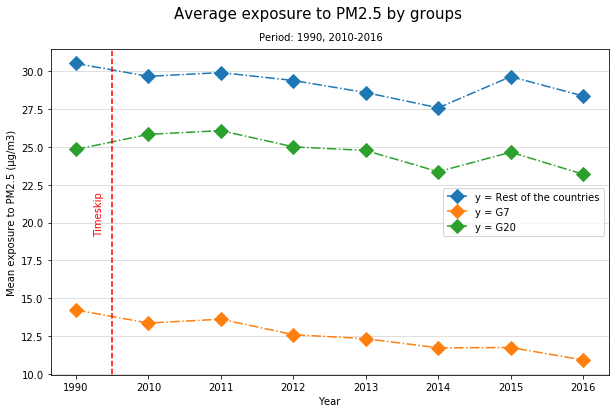

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(x_axis, groups_exposure_df,
        marker = "D",
        markersize = 10,
        linestyle = "dashdot",
        linewidth = 1.5) 
        
plt.xticks(x_axis, ["1990","2010","2011","2012","2013", "2014", "2015", "2016"])
plt.figtext(.5,.95,"Average exposure to PM2.5 by groups ", fontsize = 15, ha="center")
plt.figtext(.5,.9, "Period: 1990, 2010-2016", ha = "center")
plt.xlabel('Year')
plt.ylabel('Mean exposure to PM2.5 (µg/m3)')
plt.axvline(x=1.5, ymin=-15, ymax=35, color="r", linestyle = "--")
plt.figtext(.185,.45, "Timeskip", color = "r", rotation = 90)
plt.grid(axis = "y", alpha = .5)
plt.legend(['y = Rest of the countries', 'y = G7', 'y = G20'], loc='best')
answer_2 = input("Do you want to save the Figure (yes/no): ")
if answer_2 == "yes":
    namefile_2 = input("Provide the name of the file: ")
    plt.savefig(f"{namefile_2}_scatter.png")
plt.show()

The last graph displays the comparison between G7, G20, and countries that do not belong to either G7 and G20, showing the average exposure to PM2.5. The period covered was 1990 and from 2010-2016. In general, this figure demonstrates that developed countries are exposed to lower levels of PM2.5 than in developing countries. As can be seen, the yellow line indicates the better performance of G7 countries finding their exposure levels under 15 µg/m3 and with a decreasing trend. On the other hand, G20 and the rest of the countries' groups present exposure levels much higher than G7, having values higher than 22.5 µg/m3. It should be noted that the rebound from 2014 to 2015, which was mentioned before, is observed but only for G20 and the rest of the countries groups, indicating that G7 was not affected significantly by the issue that occurred in that year.

### Part 4 - Country Selection Analysis

In [42]:
complete_air_poll = complete_air_poll[complete_air_poll.Year != 1990]
complete_air_poll

Country  Year  Mean exposure to PM2.5 (µg/m3)  Deaths per 100,000  \
1     Australia  2010                        10.53559           13.571713   
2     Australia  2011                        10.88267           13.727626   
3     Australia  2012                        10.40148           12.659725   
4     Australia  2013                         9.84329           11.874490   
5     Australia  2014                         9.36117           11.472679   
...         ...   ...                             ...                 ...   
1291       Iran  2012                        38.80363           46.800381   
1292       Iran  2013                        38.42392           46.328081   
1293       Iran  2014                        38.27532           46.446436   
1294       Iran  2015                        39.97714           47.209842   
1295       Iran  2016                        39.19964           46.640540   

     Ratified Kyoto P. Latitude Longitude  
1                 True  -25.274   133.775  
2                 True  -25.274   133.775  
3                 True  -25.274   133.775  
4                 True  -25.274   133.775  
5                 True  -25.274   133.775  
...                ...      ...       ...  
1291              True   32.428    53.688  
1292              True   32.428    53.688  
1293              True   32.428    53.688  
1294              True   32.428    53.688  
1295              True   32.428    53.688  

[1134 rows x 7 columns]

In [43]:
print('Welcome to World Pollution Statistics, here are the countries available for analysis:')
print('----------------------------------------------------------------------------------')
countries = sorted(complete_air_poll['Country'].unique())
for i in countries:
    print(i)

Welcome to World Pollution Statistics, here are the countries available for analysis:
----------------------------------------------------------------------------------
Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
Colombia
Comoros
Costa Rica
Croatia
Cuba
Czech Republic
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Madagascar
Malawi
Malaysia
Mali
Malta
Mau

In [44]:
#User's input
repeat = 'yes'
selection =[]
response = ['yes','no']
while repeat == 'yes':
    country = input('What country would you like to select?')
    if country not in selection:
        if country in countries:
            print(f'{country} was selected')
            selection.append(country)
            repeat = input('do you want to make another selection? (yes or no)')
            while repeat not in response:
                print('select yes or no')
                repeat = input('do you want to make another selection? (yes or no)')
        else:
            print('This country does not exist or is not available in the list')
    else:
        print('This country has already been selected')
print(f'You selected {selection}')

What country would you like to select?Mexico
Mexico was selected
do you want to make another selection? (yes or no)yes
What country would you like to select?Australia
Australia was selected
do you want to make another selection? (yes or no)yes
What country would you like to select?Colombia
Colombia was selected
do you want to make another selection? (yes or no)no
You selected ['Mexico', 'Australia', 'Colombia']


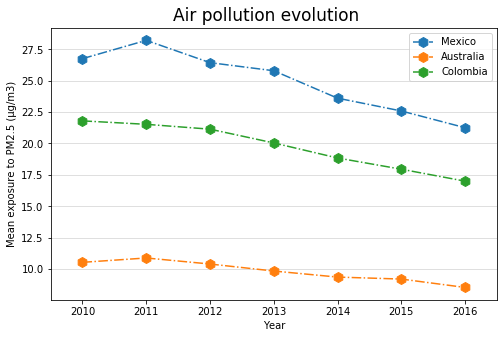

In [45]:
plt.figure(figsize=(8, 5))
for i in selection:
    x = complete_air_poll.loc[complete_air_poll['Country'] == i]['Year']
    y = complete_air_poll.loc[complete_air_poll['Country'] == i]['Mean exposure to PM2.5 (µg/m3)']
    
    
    plt.plot(x, y,
             marker = "h",
             markersize = 10,
             linestyle = "dashdot",
             linewidth = 1.5)
             

plt.figtext(.5,.9,"Air pollution evolution", fontsize = 17, ha="center")
plt.xlabel('Year')
plt.ylabel('Mean exposure to PM2.5 (µg/m3)')
plt.grid(axis = "y", alpha = .5)

plt.xlim(2009.5,2016.5)
plt.legend([i for i in selection])


plt.show()

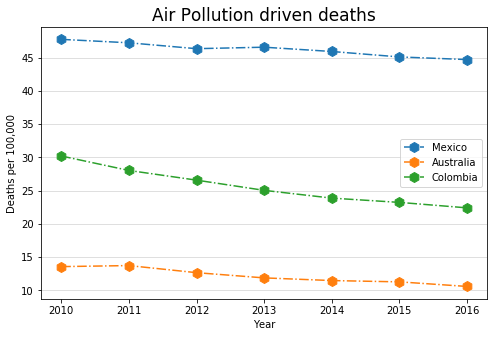

In [46]:
plt.figure(figsize=(8, 5))
for i in selection:
    x = complete_air_poll.loc[complete_air_poll['Country'] == i]['Year']
    y = complete_air_poll.loc[complete_air_poll['Country'] == i]['Deaths per 100,000']

    plt.plot(x,y,
            marker = "h",
             markersize = 10,
             linestyle = "dashdot",
             linewidth = 1.5)

plt.title('Air Pollution driven deaths', fontsize = 17)
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000')
plt.grid(axis = "y", alpha = .5)
plt.legend([i for i in selection])
plt.show()

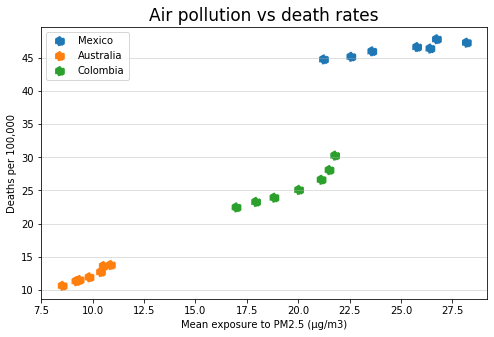

In [47]:
plt.figure(figsize=(8, 5))
for i in selection:
    x = complete_air_poll.loc[complete_air_poll['Country'] == i]['Mean exposure to PM2.5 (µg/m3)']
    y = complete_air_poll.loc[complete_air_poll['Country'] == i]['Deaths per 100,000']

    plt.scatter(x,y,
               marker = "h",
             linestyle = "dashdot",
             linewidth = 1.5,
             s = 90)

plt.title('Air pollution vs death rates', fontsize = 17)
plt.xlabel('Mean exposure to PM2.5 (µg/m3)')
plt.ylabel('Deaths per 100,000')
plt.grid(axis = "y", alpha = .5)
plt.legend([i for i in selection])
plt.show()

In [48]:
complete_air_poll = complete_air_poll.astype({'Latitude':float,'Longitude': float})

In [49]:
grouped_df = complete_air_poll.groupby(['Country']).mean()
grouped_df = grouped_df.reset_index()

In [50]:
fig_layout = {
    'width': '1000px',
    'height': '500px',
    'border': '1px solid black'}
fig = gmaps.figure(map_type='HYBRID', zoom_level = 2, center = (21.791851, 9.520398), layout = fig_layout)
locations2=[]
death2=[]

for i in selection:
    locations2.append(grouped_df.loc[grouped_df['Country'] == i][['Latitude','Longitude']].iloc[0].astype('float'))
    death2.append(grouped_df.loc[grouped_df['Country'] == i]['Mean exposure to PM2.5 (µg/m3)'].iloc[0].astype('float'))
heat_layer = gmaps.heatmap_layer(locations2,weights = death2)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='1000px'))

### Part 5 -  Target groups visualizations

In [51]:
kyoto_df = complete_air_poll.loc[complete_air_poll['Ratified Kyoto P.']==True]
non_kyoto_df = complete_air_poll.loc[complete_air_poll['Ratified Kyoto P.']==False]

### Countries that signed and Ratified Kyoto Protocol

In [52]:
fig_layout = {
    'width': '1000px',
    'height': '500px',
    'border': '1px solid black'}

fig = gmaps.figure(map_type='HYBRID', zoom_level = 2, center = (21.791851, 9.520398), layout = fig_layout)

locations = kyoto_df[['Latitude','Longitude']].astype('float')
death = kyoto_df['Mean exposure to PM2.5 (µg/m3)'].astype('float')

heat_layer = gmaps.heatmap_layer(locations,
    weights = death,
    dissipating = True,
    max_intensity = 100,
    point_radius= 12)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='1000px'))

### Countries outside Kyoto Protocol

In [53]:
fig_layout = {
    'width': '1000px',
    'height': '500px',
    'border': '1px solid black'}
fig = gmaps.figure(map_type='HYBRID', zoom_level = 2, center = (21.791851, 9.520398), layout = fig_layout)
locations = non_kyoto_df[['Latitude','Longitude']].astype('float')
death = non_kyoto_df['Mean exposure to PM2.5 (µg/m3)'].astype('float')
heat_layer = gmaps.heatmap_layer(locations,weights = death,dissipating = True,
    max_intensity = 100,
    point_radius= 12)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='1000px'))

### G7 Countries

In [54]:

fig_layout = {'width': '1000px', 'height': '500px', 'border': '1px solid black'}
    
fig = gmaps.figure(map_type='HYBRID', zoom_level = 2, center = (21.791851, 9.520398), layout = fig_layout)
locations2=[]
death2=[]
    
for i in g7:
    try:
        locations2.append(grouped_df.loc[grouped_df['Country'] == i][['Latitude','Longitude']].iloc[0].astype('float'))
        death2.append(grouped_df.loc[grouped_df['Country'] == i]['Mean exposure to PM2.5 (µg/m3)'].iloc[0].astype('float'))
    except:
        print('country not found')
    
heat_layer = gmaps.heatmap_layer(locations2,weights = death2,dissipating = True, max_intensity = 100, point_radius= 12)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', width='1000px'))

### G20 Countries

In [55]:
fig_layout = {'width': '1000px', 'height': '500px', 'border': '1px solid black'}
fig = gmaps.figure(map_type='HYBRID', zoom_level = 2, center = (21.791851, 9.520398), layout = fig_layout)
locations2=[]
death2=[]

for i in g20:
    try:
        locations2.append(grouped_df.loc[grouped_df['Country'] == i][['Latitude','Longitude']].iloc[0].astype('float'))
        death2.append(grouped_df.loc[grouped_df['Country'] == i]['Mean exposure to PM2.5 (µg/m3)'].iloc[0].astype('float'))
    except:
        print('country not found')
        
heat_layer = gmaps.heatmap_layer(locations2,weights = death2,dissipating = True, max_intensity = 100, point_radius= 12)
fig.add_layer(heat_layer)
fig

country not found
country not found
country not found


Figure(layout=FigureLayout(border='1px solid black', height='500px', width='1000px'))